In [1]:
# Import the requried modules/libraries
import re
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.gridspec import GridSpec
import textwrap
from functools import reduce
import time
import os
import json
import geopandas as gpd
import folium
import zipfile
from folium.features import DivIcon
from IPython.display import IFrame, display, HTML
from folium.plugins import MarkerCluster
from google.colab import files
from folium import GeoJson, FeatureGroup
from branca.colormap import linear
import plotly.express as px
from folium.plugins import HeatMap


# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set pandas display options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Mounted at /content/drive


### Observation:
Based on external investigation (analysis of source microfilm images and common appraisal district practices), the column previously identified as AreaSqft_1985 appears to contain administrative Area Codes (e.g., 04031) rather than physical area measurements in square feet. Furthermore, analysis confirmed that Area_1945 data is entirely missing, and Area_1975 data is approximately 98% missing, even for properties where TotalValue_YYYY exists. This makes calculating TotalValuePerSqFt for 1945 and 1975 impossible or highly unreliable using their original area columns. The AreaSqft_1985 column is also unsuitable as it doesn't represent physical area.



---

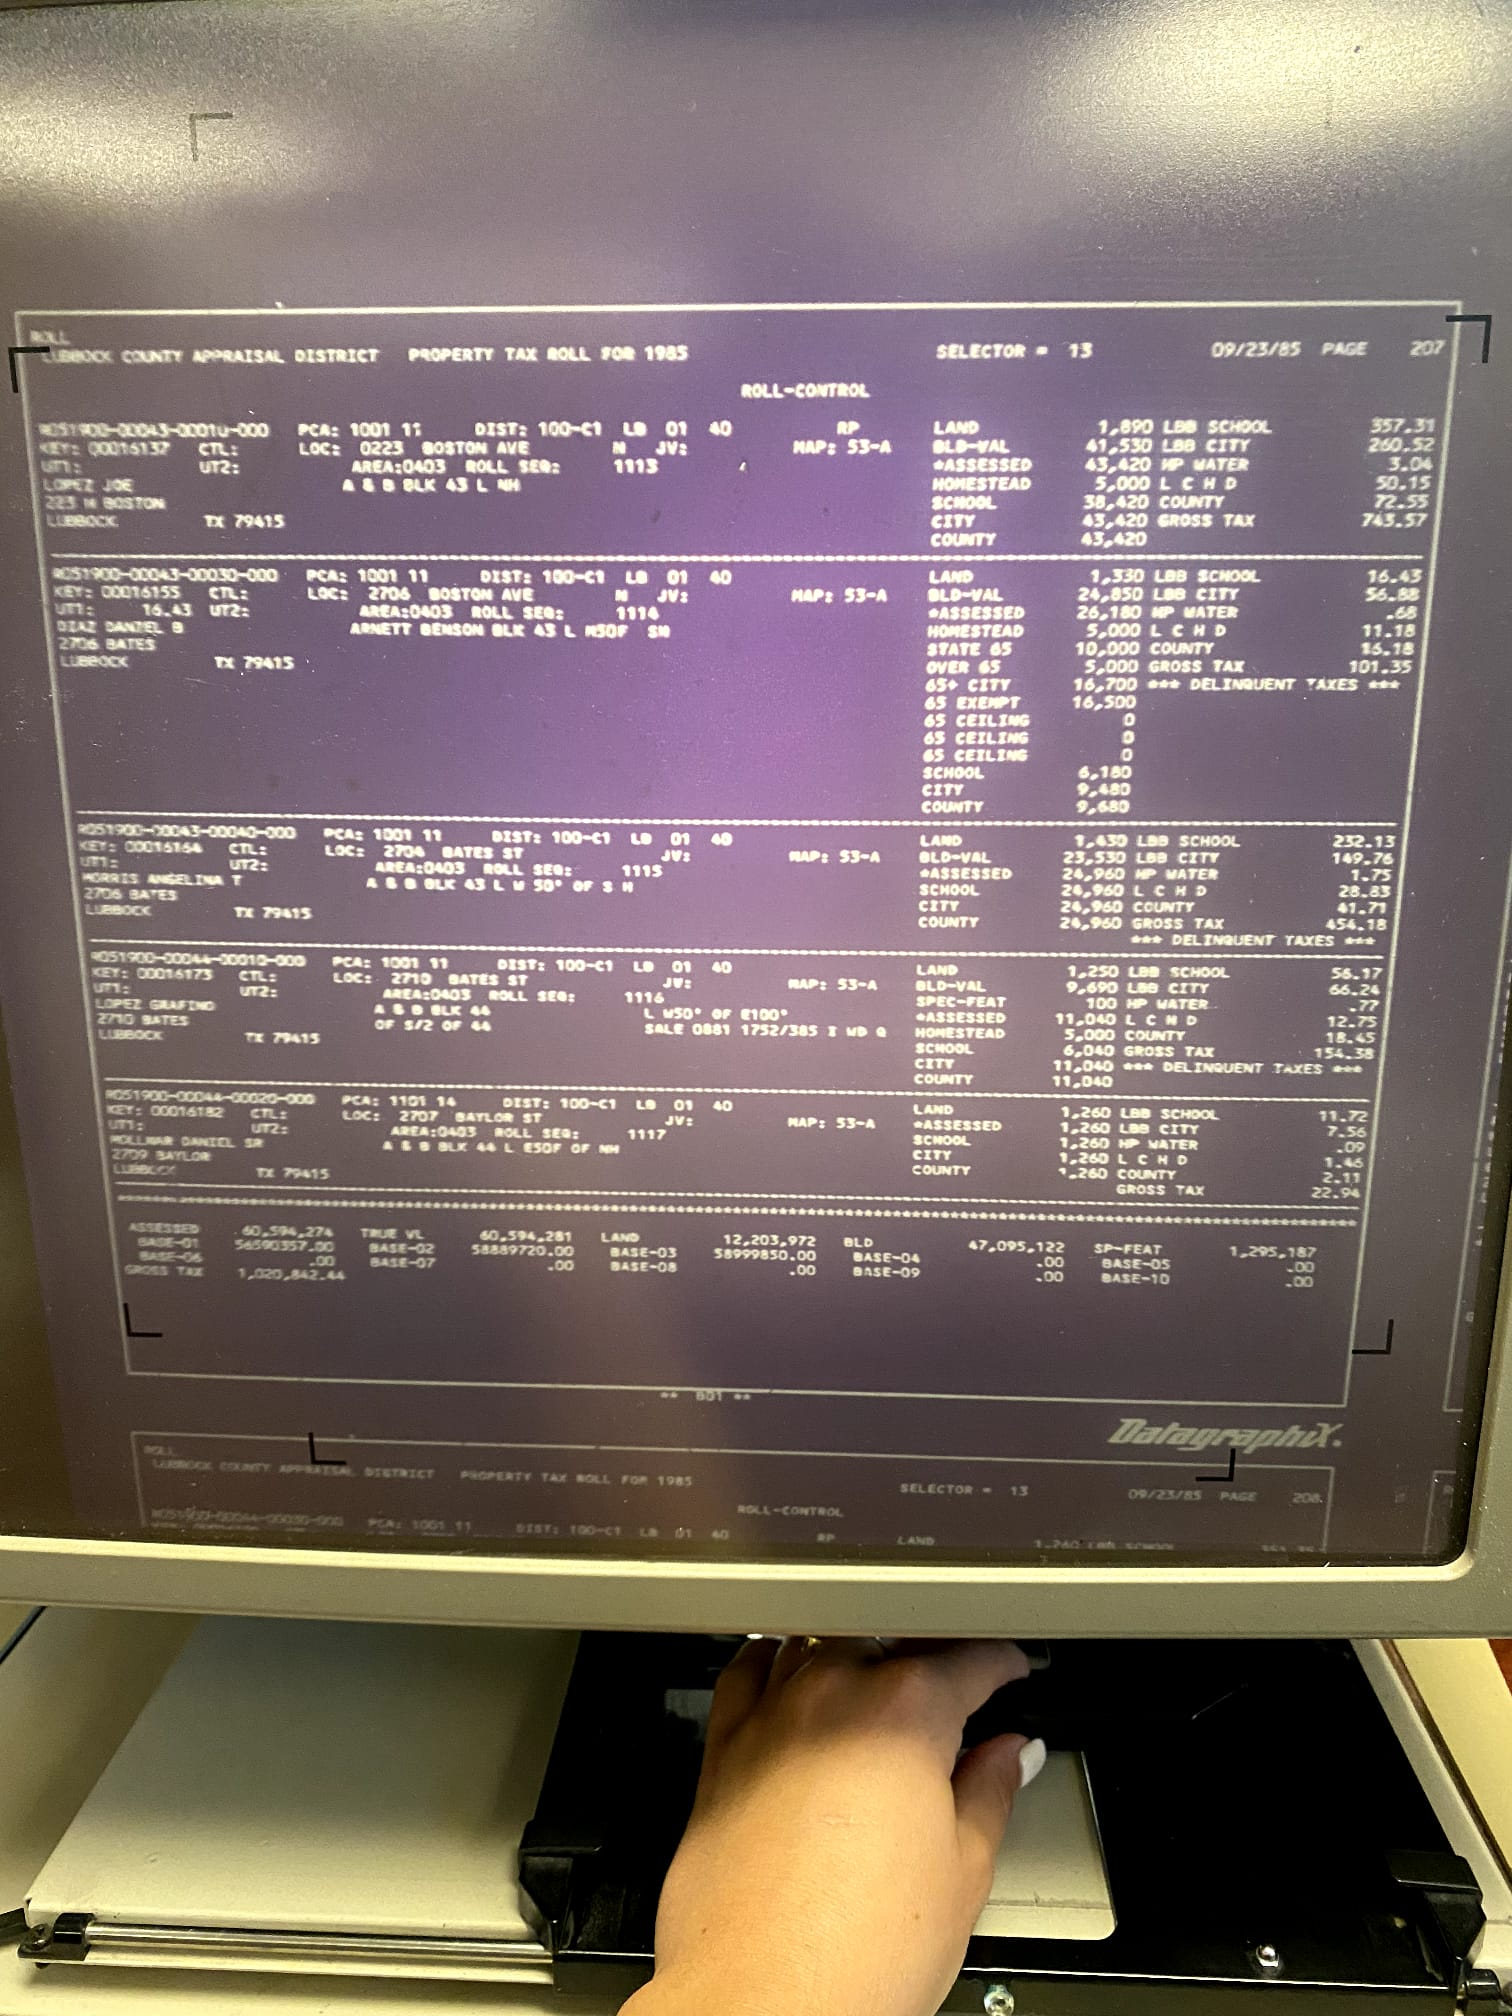

## Cell 1: Setup - Imports and Paths

**Purpose:** Import necessary libraries and define the file paths for input data and the desired output location for the modified DataFrame. Ensure the output directory exists.

In [2]:
# --- Define Paths ---
base_path = "/content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/"
input_data_path = os.path.join(base_path, "FinalData/Step3_AddedZoningData/dfall_with_zoning_details.csv")

# *** Define the SPECIFIC Output Directory and Filename ***
output_dir = os.path.join(base_path, "FinalData/Step4_WithPerSqftValues") # As requested before
output_filename = "dfall_selectively_imputed_area_SqFT_sourced.csv" # Updated name
output_data_path = os.path.join(output_dir, output_filename)

# Create output directory if it doesn't exist
print(f"Ensuring output directory exists: {output_dir}")
os.makedirs(output_dir, exist_ok=True)

print("Paths defined:")
print(f"  Input: {input_data_path}")
print(f"  Output: {output_data_path}")

Ensuring output directory exists: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/FinalData/Step4_WithPerSqftValues
Paths defined:
  Input: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/FinalData/Step3_AddedZoningData/dfall_with_zoning_details.csv
  Output: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/FinalData/Step4_WithPerSqftValues/dfall_selectively_imputed_area_SqFT_sourced.csv


## Cell 2: Load Data

**Purpose:** Load the dataset from the specified input CSV file into a pandas DataFrame. Includes basic error handling for file loading.

In [3]:
# --- Load Data ---
print(f"\nLoading data from: {input_data_path}")
try:
    df = pd.read_csv(input_data_path)
    print(f"Data loaded successfully. Initial Shape: {df.shape}")
except FileNotFoundError:
    print(f"Error: Input data file not found at {input_data_path}")
    exit()
except Exception as e:
    print(f"An error occurred during data loading: {e}")
    exit()

# Keep track of columns for final info display
initial_columns = set(df.columns)


Loading data from: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/FinalData/Step3_AddedZoningData/dfall_with_zoning_details.csv
Data loaded successfully. Initial Shape: (119184, 71)


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119184 entries, 0 to 119183
Data columns (total 71 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Address                          119184 non-null  object 
 1   ZipCode                          119184 non-null  int64  
 2   Latitude                         119184 non-null  float64
 3   Longitude                        119184 non-null  float64
 4   ValueOfCityProperty_1945         2037 non-null    float64
 5   ValueOfPersonalProperty_1945     297 non-null     float64
 6   TotalValue_1945                  2186 non-null    float64
 7   F2025DollarValueTotalValue_1945  2186 non-null    float64
 8   StateTax_1945                    433 non-null     float64
 9   CountyTax_1945                   1279 non-null    float64
 10  GrossTax_1945                    1298 non-null    float64
 11  Area_1945                        0 non-null       float64
 12  Ho

## Cell 3: Define Columns and Constants

In [5]:
# --- Define Columns & Years ---

# Years involved
all_years = ['1945', '1975', '1985', '2012', '2020', '2021']
historical_years = ['1945', '1975', '1985']
recent_years = ['2012', '2020', '2021']

# Columns to delete
cols_to_delete = [
    'Area_1945',
    'Area_1975',
    'AreaSqm_1985',
    'AreaSqft_1985', # Old 1985 area col (likely area code)
    'LandSizeAC_2012',
    'LandSizeAC_2020',
    'LandSizeAC_2021'
]

# Columns to rename (Source FT -> Target SqFT)
rename_map_ft_to_sqft = {f'LandSizeFT_{year}': f'LandSizeSqFT_{year}' for year in recent_years}
source_area_cols = list(rename_map_ft_to_sqft.keys()) # Original names like 'LandSizeFT_2012'
target_recent_area_cols = list(rename_map_ft_to_sqft.values()) # Target names like 'LandSizeSqFT_2012'

# New historical SqFT columns to create (will be populated later)
target_historical_area_cols = [f'LandSizeSqFT_{year}' for year in historical_years]

# Fallback sequence using the *target* (renamed) column names
imputation_source_cols_sqft = target_recent_area_cols # ['LandSizeSqFT_2012', 'LandSizeSqFT_2020', 'LandSizeSqFT_2021']

# New indicator columns
indicator_cols = [f'BelongTo_{year}' for year in all_years]

# **New: Column to store the source of imputation**
imputation_source_tracker_col = 'LandSizeSqFT_ImputationSource'

print("Column names and year lists defined.")

Column names and year lists defined.


## Cell 4: Initial Column Cleanup - Deletions


In [6]:
print("\n--- Step 1: Deleting Obsolete/Incorrect Area Columns ---")
existing_cols_to_delete = [col for col in cols_to_delete if col in df.columns]
if existing_cols_to_delete:
    print(f"Deleting columns: {', '.join(existing_cols_to_delete)}")
    df.drop(columns=existing_cols_to_delete, inplace=True, errors='ignore')
    print("Deletion complete.")
else:
    print("No columns found matching the deletion list.")


--- Step 1: Deleting Obsolete/Incorrect Area Columns ---
Deleting columns: Area_1945, Area_1975, AreaSqm_1985, AreaSqft_1985, LandSizeAC_2012, LandSizeAC_2020, LandSizeAC_2021
Deletion complete.


## Cell 5: Rename Recent Land Size Columns

In [7]:
print("\n--- Step 2: Renaming Recent Land Size Columns (FT -> SqFT) ---")
cols_to_rename_actually_exist = {k: v for k, v in rename_map_ft_to_sqft.items() if k in df.columns}
if cols_to_rename_actually_exist:
    print(f"Renaming: {cols_to_rename_actually_exist}")
    df.rename(columns=cols_to_rename_actually_exist, inplace=True)
    rename_successful = all(v in df.columns for v in cols_to_rename_actually_exist.values())
    if rename_successful: print("Renaming successful.")
    else: print("Warning: Some columns might not have been renamed correctly.")
else:
    print("No columns found matching the rename list (maybe already renamed?).")
    target_names_exist = all(v in df.columns for v in rename_map_ft_to_sqft.values())
    if target_names_exist: print("Target names (e.g., 'LandSizeSqFT_2012') already exist.")
    else: print("Warning: Neither source nor target names found for recent area columns.")


--- Step 2: Renaming Recent Land Size Columns (FT -> SqFT) ---
Renaming: {'LandSizeFT_2012': 'LandSizeSqFT_2012', 'LandSizeFT_2020': 'LandSizeSqFT_2020', 'LandSizeFT_2021': 'LandSizeSqFT_2021'}
Renaming successful.


## Cell 6: Clean Renamed Source Columns

In [8]:
print("\n--- Step 3: Cleaning Source Land Size Columns (Replacing 0 with NaN) ---")
cleaned_count = 0
for col in target_recent_area_cols: # Use the NEW names after renaming
    if col in df.columns:
        zeros_before = (df[col] == 0).sum()
        if zeros_before > 0:
            print(f"Found {zeros_before} zero values in '{col}'. Replacing with NaN...")
            df[col] = df[col].replace(0, np.nan)
            cleaned_count += zeros_before
            zeros_after = (df[col] == 0).sum()
            if zeros_after == 0: print(f"Successfully replaced zeros in '{col}'.")
            else: print(f"Warning: Failed to replace all zeros in '{col}'.")
        else:
            print(f"No zero values found in '{col}'.")
    else:
        print(f"Warning: Source column '{col}' not found for cleaning.")

if cleaned_count > 0: print(f"\nTotal zero values replaced across source columns: {cleaned_count}")
print("--- Source Column Cleaning Complete ---")


--- Step 3: Cleaning Source Land Size Columns (Replacing 0 with NaN) ---
Found 2526 zero values in 'LandSizeSqFT_2012'. Replacing with NaN...
Successfully replaced zeros in 'LandSizeSqFT_2012'.
Found 2239 zero values in 'LandSizeSqFT_2020'. Replacing with NaN...
Successfully replaced zeros in 'LandSizeSqFT_2020'.
Found 2122 zero values in 'LandSizeSqFT_2021'. Replacing with NaN...
Successfully replaced zeros in 'LandSizeSqFT_2021'.

Total zero values replaced across source columns: 6887
--- Source Column Cleaning Complete ---


## Cell 7: Create 'BelongTo_YYYY' Indicator Columns

In [9]:
print("\n--- Step 4: Creating 'BelongTo_YYYY' Indicator Columns ---")
for year in all_years:
    value_col = f'TotalValue_{year}'
    indicator_col = f'BelongTo_{year}'
    if value_col in df.columns:
        print(f"Creating '{indicator_col}' based on '{value_col}'...")
        df[indicator_col] = df[value_col].notna().astype(int)
        ones_count = df[indicator_col].sum()
        print(f"  '{indicator_col}' created. Count of properties belonging to {year}: {ones_count}")
    else:
        print(f"Warning: Value column '{value_col}' not found. Cannot create '{indicator_col}'.")
        df[indicator_col] = 0

print("--- Indicator Column Creation Complete ---")


--- Step 4: Creating 'BelongTo_YYYY' Indicator Columns ---
Creating 'BelongTo_1945' based on 'TotalValue_1945'...
  'BelongTo_1945' created. Count of properties belonging to 1945: 2186
Creating 'BelongTo_1975' based on 'TotalValue_1975'...
  'BelongTo_1975' created. Count of properties belonging to 1975: 26346
Creating 'BelongTo_1985' based on 'TotalValue_1985'...
  'BelongTo_1985' created. Count of properties belonging to 1985: 13251
Creating 'BelongTo_2012' based on 'TotalValue_2012'...
  'BelongTo_2012' created. Count of properties belonging to 2012: 99599
Creating 'BelongTo_2020' based on 'TotalValue_2020'...
  'BelongTo_2020' created. Count of properties belonging to 2020: 110873
Creating 'BelongTo_2021' based on 'TotalValue_2021'...
  'BelongTo_2021' created. Count of properties belonging to 2021: 113054
--- Indicator Column Creation Complete ---


## Cell 8: Prepare Combined Imputation Source Data AND Track Source Year

In [10]:
print("\n--- Step 5: Preparing Combined Imputation Source AND Tracking Source Year ---")

# Verify the source columns (now named LandSizeSqFT_YYYY) exist
valid_source_cols_sqft = [col for col in imputation_source_cols_sqft if col in df.columns]

if not valid_source_cols_sqft:
    print("Error: None of the source SqFt columns for imputation exist. Cannot proceed.")
    exit()
elif len(valid_source_cols_sqft) < len(imputation_source_cols_sqft):
     print(f"Warning: Using available source columns for fallback: {valid_source_cols_sqft}")

# --- Create the combined source series (for the value) ---
combined_source_data = pd.Series(index=df.index, dtype=float) # Initialize
if valid_source_cols_sqft:
    print(f"Calculating combined imputation value using fallback: {valid_source_cols_sqft}")
    combined_source_data = df[valid_source_cols_sqft[0]].copy()
    for i in range(1, len(valid_source_cols_sqft)):
        combined_source_data = combined_source_data.combine_first(df[valid_source_cols_sqft[i]])

# --- Determine and store the source year ---
print(f"Determining and storing the source year in '{imputation_source_tracker_col}'...")
df[imputation_source_tracker_col] = None # Initialize column with None or np.nan

# Apply in reverse order of priority so higher priority overwrites lower
source_years_map = {
    'LandSizeSqFT_2012': '2012',
    'LandSizeSqFT_2020': '2020',
    'LandSizeSqFT_2021': '2021'
}

# Iterate through the available source columns in the defined fallback order
for source_col in reversed(valid_source_cols_sqft): # Check 2021, then 2020, then 2012
     source_year_label = source_years_map.get(source_col)
     if source_year_label:
          # Assign the source year label where the source column is not NaN
          # This ensures later assignments (higher priority) overwrite earlier ones
          df.loc[df[source_col].notna(), imputation_source_tracker_col] = source_year_label

# Report on final missing count after fallback
final_nan_count = combined_source_data.isna().sum()
imputation_source_counts = df[imputation_source_tracker_col].value_counts(dropna=False) # Include NaNs

print(f"\nCombined source value series created.")
print(f"Source year tracking complete in '{imputation_source_tracker_col}'.")
print(f"Source distribution:\n{imputation_source_counts.to_markdown()}")
if final_nan_count > 0:
     print(f"\nNote: {final_nan_count} properties still have missing land size after checking ALL source years.")

print("--- Combined Imputation Source and Tracking Prepared ---")


--- Step 5: Preparing Combined Imputation Source AND Tracking Source Year ---
Calculating combined imputation value using fallback: ['LandSizeSqFT_2012', 'LandSizeSqFT_2020', 'LandSizeSqFT_2021']
Determining and storing the source year in 'LandSizeSqFT_ImputationSource'...

Combined source value series created.
Source year tracking complete in 'LandSizeSqFT_ImputationSource'.
Source distribution:
|   LandSizeSqFT_ImputationSource |   count |
|--------------------------------:|--------:|
|                            2012 |   97072 |
|                            2020 |   13456 |
|                                 |    6159 |
|                            2021 |    2497 |

Note: 6159 properties still have missing land size after checking ALL source years.
--- Combined Imputation Source and Tracking Prepared ---


## Cell 9: Create and Selectively Impute Historical Area Columns

In [11]:
print("\n--- Step 6: Creating and Selectively Imputing Historical Area Columns ---")

for year in historical_years:
    target_col = f'LandSizeSqFT_{year}'
    indicator_col = f'BelongTo_{year}'

    print(f"\nProcessing year {year}:")
    # Initialize target column with NaNs
    print(f"  Initializing '{target_col}' with NaN...")
    df[target_col] = np.nan

    if indicator_col not in df.columns or df[indicator_col].sum() == 0:
        print(f"  Indicator column '{indicator_col}' not found or has no '1's. Skipping imputation for {target_col}.")
        continue

    mask = (df[indicator_col] == 1)
    num_to_impute = mask.sum()
    print(f"  Identifying {num_to_impute} properties where '{indicator_col}' is 1.")

    print(f"  Assigning values from combined source to '{target_col}' for selected properties...")
    df.loc[mask, target_col] = combined_source_data[mask] # Use the pre-calculated combined values

    # Report results
    imputed_count = df.loc[mask, target_col].notna().sum()
    source_nan_count_for_subset = combined_source_data[mask].isna().sum() # Count how many couldn't be imputed
    print(f"  Successfully assigned {imputed_count} values into '{target_col}'.")
    if source_nan_count_for_subset > 0:
        print(f"  ({source_nan_count_for_subset} properties belonging to {year} had no land size available from sources {valid_source_cols_sqft}).")

print("\n--- Selective Historical Imputation Complete ---")


--- Step 6: Creating and Selectively Imputing Historical Area Columns ---

Processing year 1945:
  Initializing 'LandSizeSqFT_1945' with NaN...
  Identifying 2186 properties where 'BelongTo_1945' is 1.
  Assigning values from combined source to 'LandSizeSqFT_1945' for selected properties...
  Successfully assigned 1578 values into 'LandSizeSqFT_1945'.
  (608 properties belonging to 1945 had no land size available from sources ['LandSizeSqFT_2012', 'LandSizeSqFT_2020', 'LandSizeSqFT_2021']).

Processing year 1975:
  Initializing 'LandSizeSqFT_1975' with NaN...
  Identifying 26346 properties where 'BelongTo_1975' is 1.
  Assigning values from combined source to 'LandSizeSqFT_1975' for selected properties...
  Successfully assigned 23553 values into 'LandSizeSqFT_1975'.
  (2793 properties belonging to 1975 had no land size available from sources ['LandSizeSqFT_2012', 'LandSizeSqFT_2020', 'LandSizeSqFT_2021']).

Processing year 1985:
  Initializing 'LandSizeSqFT_1985' with NaN...
  Identi

## Cell 10: Verification

In [12]:
print("\n--- Step 7: Verification ---")
print("Verifying key columns (showing first 10 rows):")

# Select columns for verification
verify_indicator_cols = [f'BelongTo_{year}' for year in all_years]
verify_area_cols = [f'LandSizeSqFT_{year}' for year in all_years]
# ** Add the imputation source tracker column **
verify_cols = verify_indicator_cols + verify_area_cols + [imputation_source_tracker_col]

# Filter out any columns that might not exist after checks/warnings
verify_cols = [col for col in verify_cols if col in df.columns]
# Optional: Sort for readability
if imputation_source_tracker_col in verify_cols:
    # Keep tracker col at the end
    verify_cols.remove(imputation_source_tracker_col)
    verify_cols = sorted(verify_cols, key = lambda x: (x[-4:], x[0])) # Sort by year, then prefix
    verify_cols.append(imputation_source_tracker_col) # Add tracker back
else:
    verify_cols = sorted(verify_cols, key = lambda x: (x[-4:], x[0]))

if verify_cols:
    print(df[verify_cols].head(10).to_markdown(index=False, numalign="left", stralign="left"))
else:
    print("Could not find relevant columns to display verification.")

# Display counts from the source tracker column again for clarity
print("\n--- Imputation Source Summary ---")
if imputation_source_tracker_col in df.columns:
    source_counts = df[imputation_source_tracker_col].value_counts(dropna=False)
    print("Number of properties where land size was sourced from:")
    print(source_counts.to_markdown())
else:
    print(f"Tracker column '{imputation_source_tracker_col}' not found.")


print("\n--- Checking Final DataFrame Info ---")
df.info()


--- Step 7: Verification ---
Verifying key columns (showing first 10 rows):
| BelongTo_1945   | LandSizeSqFT_1945   | BelongTo_1975   | LandSizeSqFT_1975   | BelongTo_1985   | LandSizeSqFT_1985   | BelongTo_2012   | LandSizeSqFT_2012   | BelongTo_2020   | LandSizeSqFT_2020   | BelongTo_2021   | LandSizeSqFT_2021   | LandSizeSqFT_ImputationSource   |
|:----------------|:--------------------|:----------------|:--------------------|:----------------|:--------------------|:----------------|:--------------------|:----------------|:--------------------|:----------------|:--------------------|:--------------------------------|
| 0               | nan                 | 0               | nan                 | 1               | nan                 | 0               | nan                 | 0               | nan                 | 0               | nan                 |                                 |
| 0               | nan                 | 0               | nan                 | 1            

## Cell 11: Save Modified Data

In [13]:
# Define the desired column order
column_order = [
    'Address', 'ZipCode', 'Latitude', 'Longitude',
    'ValueOfCityProperty_1945', 'ValueOfPersonalProperty_1945', 'TotalValue_1945',
    'F2025DollarValueTotalValue_1945', 'Homestead_1945', 'StateTax_1945',
    'CountyTax_1945', 'DistrictSchool_1945', 'GrossTax_1945', 'AddressRepetition_1945',
    'BelongTo_1945', 'LandSizeSqFT_1945', 'StateValueDollars_1975',
    'ValueOfCityProperty_1975', 'ValueOfPersonalProperty_1975', 'TotalValue_1975',
    'F2025DollarValueTotalValue_1975', 'Homestead_1975', 'StateTax_1975',
    'CountyTax_1975', 'DistrictSchool_1975', 'GrossTax_1975', 'AddressRepetition_1975',
    'BelongTo_1975', 'LandSizeSqFT_1975', 'LandValue__1985', 'BuildingValue_1985',
    'SpecialFeaturesValue_1985', 'TotalValue_1985', 'F2025DollarValueTotalValue_1985',
    'Homestead_1985', 'CountyTax_1985', 'CityTax_1985', 'SchoolTax_1985',
    'LCHDTax_1985', 'GrossTax_1985', 'SchoolValue_1985', 'CountyValue_1985',
    'CityValue_1985', 'AddressRepetition_1985', 'BelongTo_1985', 'LandSizeSqFT_1985',
    'TotalValue_2012', 'F2025DollarValueTotalValue_2012', 'LandValue_2012',
    'ImpValue_2012', 'YearBuilt_2012', 'BelongTo_2012', 'LandSizeSqFT_2012',
    'TotalValue_2020', 'F2025DollarValueTotalValue_2020', 'LandValue_2020',
    'ImpValue_2020', 'YearBuilt_2020', 'BelongTo_2020', 'LandSizeSqFT_2020',
    'TotalValue_2021', 'F2025DollarValueTotalValue_2021', 'LandValue_2021',
    'ImpValue_2021', 'YearBuilt_2021', 'BelongTo_2021', 'LandSizeSqFT_2021',
    'ValuePresence', 'IsInLubbock', 'IsInCouncilDistrict', 'IsInRedliningZone',
    'IsInRedliningZone_half_mile', 'IsInRedliningZone_one_mile',
    'LandSizeSqFT_ImputationSource'
]

# Reorder the columns
df = df[column_order]

In [14]:
# --- Step 8: Save Modified Data ---
print(f"\n--- Saving Modified DataFrame ---")
print(f"Saving data to: {output_data_path}")
try:
    df.to_csv(output_data_path, index=False)
    print("Modified data saved successfully.")
except Exception as e:
    print(f"An error occurred while saving the data: {e}")
print("\n--- Processing Complete ---")


--- Saving Modified DataFrame ---
Saving data to: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/FinalData/Step4_WithPerSqftValues/dfall_selectively_imputed_area_SqFT_sourced.csv
Modified data saved successfully.

--- Processing Complete ---


## Cell 12: Calculate Total Value Per Square Foot (Conditional)
**Purpose:** Create six new columns, TotalValuePerSqFT_YYYY, representing the total property value divided by the land size in square feet for each respective year.

**Logic:**

1. Iterate through each relevant year (1945 to 2021).
2. For each year, identify the corresponding TotalValue_YYYY and LandSizeSqFT_YYYY columns.
3. Create a condition (boolean mask) that is True only for rows where:
 1. TotalValue_YYYY is not missing (NaN).
 2. LandSizeSqFT_YYYY is not missing (NaN).
 3. LandSizeSqFT_YYYY is greater than 0.

4. Initialize the new TotalValuePerSqFT_YYYY column with NaN.

5. Perform the division (TotalValue_YYYY / LandSizeSqFT_YYYY) and assign the result to the new column, but only for the rows where the condition is True. Rows not meeting the condition will retain the initial NaN value.

In [15]:
column_categories = {
    '1945': [
        'ValueOfCityProperty_1945',
        'ValueOfPersonalProperty_1945',
        'TotalValue_1945',
        'F2025DollarValueTotalValue_1945',
        'Homestead_1945',
        'StateTax_1945',
        'CountyTax_1945',
        'DistrictSchool_1945',
        'GrossTax_1945',
        'AddressRepetition_1945',
        'BelongTo_1945',
        'LandSizeSqFT_1945'
    ],
    '1975': [
        'StateValueDollars_1975',
        'ValueOfCityProperty_1975',
        'ValueOfPersonalProperty_1975',
        'TotalValue_1975',
        'F2025DollarValueTotalValue_1975',
        'Homestead_1975',
        'StateTax_1975',
        'CountyTax_1975',
        'DistrictSchool_1975',
        'GrossTax_1975',
        'AddressRepetition_1975',
        'BelongTo_1975',
        'LandSizeSqFT_1975'
    ],
    '1985': [
        'LandValue__1985',
        'BuildingValue_1985',
        'SpecialFeaturesValue_1985',
        'TotalValue_1985',
        'F2025DollarValueTotalValue_1985',
        'Homestead_1985',
        'CountyTax_1985',
        'CityTax_1985',
        'SchoolTax_1985',
        'LCHDTax_1985',
        'GrossTax_1985',
        'SchoolValue_1985',
        'CountyValue_1985',
        'CityValue_1985',
        'AddressRepetition_1985',
        'BelongTo_1985',
        'LandSizeSqFT_1985'
    ],
    '2012': [
        'TotalValue_2012',
        'F2025DollarValueTotalValue_2012',
        'LandValue_2012',
        'ImpValue_2012',
        'YearBuilt_2012',
        'BelongTo_2012',
        'LandSizeSqFT_2012'
    ],
    '2020': [
        'TotalValue_2020',
        'F2025DollarValueTotalValue_2020',
        'LandValue_2020',
        'ImpValue_2020',
        'YearBuilt_2020',
        'BelongTo_2020',
        'LandSizeSqFT_2020'
    ],
    '2021': [
        'TotalValue_2021',
        'F2025DollarValueTotalValue_2021',
        'LandValue_2021',
        'ImpValue_2021',
        'YearBuilt_2021',
        'BelongTo_2021',
        'LandSizeSqFT_2021'
    ],
    'Location': [
        'Address',
        'ZipCode',
        'Latitude',
        'Longitude'
    ],
    'Zone_Indicators': [
        'ValuePresence',
        'IsInLubbock',
        'IsInCouncilDistrict',
        'IsInRedliningZone',
        'IsInRedliningZone_half_mile',
        'IsInRedliningZone_one_mile'
    ],
    'Imputation': [
        'LandSizeSqFT_ImputationSource'
    ]
}

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119184 entries, 0 to 119183
Data columns (total 74 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Address                          119184 non-null  object 
 1   ZipCode                          119184 non-null  int64  
 2   Latitude                         119184 non-null  float64
 3   Longitude                        119184 non-null  float64
 4   ValueOfCityProperty_1945         2037 non-null    float64
 5   ValueOfPersonalProperty_1945     297 non-null     float64
 6   TotalValue_1945                  2186 non-null    float64
 7   F2025DollarValueTotalValue_1945  2186 non-null    float64
 8   Homestead_1945                   1125 non-null    float64
 9   StateTax_1945                    433 non-null     float64
 10  CountyTax_1945                   1279 non-null    float64
 11  DistrictSchool_1945              0 non-null       float64
 12  Gr

In [17]:
print("--- Calculating Total Value Per Square Foot ---")

all_years = ['1945', '1975', '1985', '2012', '2020', '2021']
new_per_sqft_cols = [] # Keep track of newly created columns

for year in all_years:
    value_col = f'TotalValue_{year}'
    area_col = f'LandSizeSqFT_{year}'
    per_sqft_col = f'TotalValuePerSqFT_{year}'
    new_per_sqft_cols.append(per_sqft_col)

    print(f"\nProcessing year {year}:")

    # Check if required input columns exist
    if value_col not in df.columns:
        print(f"  Skipping: Value column '{value_col}' not found.")
        df[per_sqft_col] = np.nan # Create column with NaNs if input missing
        continue
    if area_col not in df.columns:
        print(f"  Skipping: Area column '{area_col}' not found.")
        df[per_sqft_col] = np.nan # Create column with NaNs if input missing
        continue

    # 1. Define the condition for valid calculation
    condition = (
        df[value_col].notna() &
        df[area_col].notna() &
        (df[area_col] > 0)
    )
    valid_rows_count = condition.sum()
    print(f"  Found {valid_rows_count} rows meeting criteria for '{per_sqft_col}' calculation.")

    # 2. Initialize the new column with NaN
    df[per_sqft_col] = np.nan

    # 3. Perform calculation only where condition is True
    if valid_rows_count > 0:
        print(f"  Calculating '{value_col}' / '{area_col}'...")
        # Use .loc[condition, col] for safe assignment based on boolean mask
        df.loc[condition, per_sqft_col] = df.loc[condition, value_col] / df.loc[condition, area_col]
        print(f"  Finished calculating '{per_sqft_col}'.")
    else:
        print(f"  No rows met the criteria; '{per_sqft_col}' remains NaN.")

print("\n--- Total Value Per Square Foot Calculation Complete ---")

--- Calculating Total Value Per Square Foot ---

Processing year 1945:
  Found 1578 rows meeting criteria for 'TotalValuePerSqFT_1945' calculation.
  Calculating 'TotalValue_1945' / 'LandSizeSqFT_1945'...
  Finished calculating 'TotalValuePerSqFT_1945'.

Processing year 1975:
  Found 23553 rows meeting criteria for 'TotalValuePerSqFT_1975' calculation.
  Calculating 'TotalValue_1975' / 'LandSizeSqFT_1975'...
  Finished calculating 'TotalValuePerSqFT_1975'.

Processing year 1985:
  Found 12251 rows meeting criteria for 'TotalValuePerSqFT_1985' calculation.
  Calculating 'TotalValue_1985' / 'LandSizeSqFT_1985'...
  Finished calculating 'TotalValuePerSqFT_1985'.

Processing year 2012:
  Found 97072 rows meeting criteria for 'TotalValuePerSqFT_2012' calculation.
  Calculating 'TotalValue_2012' / 'LandSizeSqFT_2012'...
  Finished calculating 'TotalValuePerSqFT_2012'.

Processing year 2020:
  Found 108634 rows meeting criteria for 'TotalValuePerSqFT_2020' calculation.
  Calculating 'TotalVal

**Purpose:** Display the first few rows of the newly created TotalValuePerSqFT_YYYY columns along with their corresponding Value and Area columns to verify the calculation. Also, show the DataFrame info to confirm the new columns and their non-null counts.



In [18]:
print("\n--- Verifying Per Square Foot Columns (First 5 Rows) ---")

# Select relevant columns for verification
verify_cols = []
for year in all_years:
    value_col = f'TotalValue_{year}'
    area_col = f'LandSizeSqFT_{year}'
    per_sqft_col = f'TotalValuePerSqFT_{year}'
    # Add columns only if they actually exist in the DataFrame
    if value_col in df.columns: verify_cols.append(value_col)
    if area_col in df.columns: verify_cols.append(area_col)
    if per_sqft_col in df.columns: verify_cols.append(per_sqft_col)

# Filter out duplicates and sort if needed
verify_cols = sorted(list(set(verify_cols)), key = lambda x: (x[-4:], x[0]))

if verify_cols:
    print(df[verify_cols].head().to_markdown(index=False, numalign="left", stralign="left"))
else:
    print("Could not find relevant columns to display verification.")


print("\n--- Checking Final DataFrame Info ---")
df.info()


--- Verifying Per Square Foot Columns (First 5 Rows) ---
| LandSizeSqFT_1945   | TotalValuePerSqFT_1945   | TotalValue_1945   | LandSizeSqFT_1975   | TotalValuePerSqFT_1975   | TotalValue_1975   | LandSizeSqFT_1985   | TotalValue_1985   | TotalValuePerSqFT_1985   | LandSizeSqFT_2012   | TotalValuePerSqFT_2012   | TotalValue_2012   | LandSizeSqFT_2020   | TotalValue_2020   | TotalValuePerSqFT_2020   | LandSizeSqFT_2021   | TotalValue_2021   | TotalValuePerSqFT_2021   |
|:--------------------|:-------------------------|:------------------|:--------------------|:-------------------------|:------------------|:--------------------|:------------------|:-------------------------|:--------------------|:-------------------------|:------------------|:--------------------|:------------------|:-------------------------|:--------------------|:------------------|:-------------------------|
| nan                 | nan                      | nan               | nan                 | nan              

## Cell 13: Define Function and Create `ValuePresencePerSqFT` Column

**Purpose:** Define a function that checks the presence of non-NaN values in the `TotalValuePerSqFT_YYYY` columns for a given row and returns a space-separated string of the years where data is present. Apply this function row-wise to create the new `ValuePresencePerSqFT` column.

In [19]:
print("--- Creating 'ValuePresencePerSqFT' Column ---")

all_years = ['1945', '1975', '1985', '2012', '2020', '2021']
target_col_name = 'ValuePresencePerSqFT'

def get_per_sqft_presence(row):
    """
    Checks a row for non-NaN values in TotalValuePerSqFT_YYYY columns
    and returns a space-separated string of years where data is present.
    """
    present_years = []
    for year in all_years:
        col_name = f'TotalValuePerSqFT_{year}'
        # Check if column exists in the row's index and if value is not NaN
        if col_name in row.index and pd.notna(row[col_name]):
            present_years.append(year)

    if not present_years:
        return "None" # Or return "" (empty string) if preferred
    else:
        return " ".join(present_years)

# Apply the function row-wise (axis=1)
df[target_col_name] = df.apply(get_per_sqft_presence, axis=1)

print(f"Column '{target_col_name}' created successfully.")
print("--- Column Creation Complete ---")

--- Creating 'ValuePresencePerSqFT' Column ---
Column 'ValuePresencePerSqFT' created successfully.
--- Column Creation Complete ---


**Purpose:** Display the value counts for the new `ValuePresencePerSqFT` column to understand the distribution of availability patterns for the per-square-foot metric. Compare this mentally (or programmatically if desired) to the original `ValuePresence` counts to see where the area data limitations impacted the final calculation.

In [20]:
print("\n--- Verifying 'ValuePresencePerSqFT' Column ---")

print(f"\nValue Counts for '{target_col_name}':")
value_counts_per_sqft = df[target_col_name].value_counts()
print(value_counts_per_sqft.to_markdown())

# Optional: Compare counts with original ValuePresence
print("\nValue Counts for 'ValuePresence':")
print(df['ValuePresence'].value_counts().to_markdown())

print("\n--- Verification Complete ---")


--- Verifying 'ValuePresencePerSqFT' Column ---

Value Counts for 'ValuePresencePerSqFT':
| ValuePresencePerSqFT          |   count |
|:------------------------------|--------:|
| 2012 2020 2021                |   65779 |
| 1975 2012 2020 2021           |   15970 |
| 2020 2021                     |   13308 |
| 1975 1985 2012 2020 2021      |    6655 |
| None                          |    6159 |
| 1985 2012 2020 2021           |    5072 |
| 2021                          |    2485 |
| 2012                          |    1753 |
| 1945 2012 2020 2021           |     626 |
| 1945 1975 2012 2020 2021      |     478 |
| 1945 1975 1985 2012 2020 2021 |     281 |
| 1945 1985 2012 2020 2021      |     165 |
| 2012 2020                     |     146 |
| 1975 2012                     |      75 |
| 2020                          |      60 |
| 1975 2020 2021                |      45 |
| 1985 2012                     |      24 |
| 1975 1985 2020 2021           |      18 |
| 1975 1985 2012             

## Cell 14: Calculate Inflation-Adjusted Per Square Foot Values

**Purpose:** Create the new F2025TotalValuePerSqFT_YYYY columns by multiplying the corresponding TotalValuePerSqFT_YYYY column by the inflation factor for that year. Handle potential missing values (NaN).

In [21]:
# --- Define Inflation Factors (to 2025 Dollars) ---
inflation_factors = {
    '1945': 17.53,
    '1975': 5.87,
    '1985': 2.93,
    '2012': 1.37,
    '2020': 1.22,
    '2021': 1.16
}
print("Inflation factors defined.")

print("\n--- Calculating Inflation-Adjusted Per Square Foot Values (to 2025$) ---")

all_years = ['1945', '1975', '1985', '2012', '2020', '2021']
new_f2025_cols = [] # Keep track of new columns

for year in all_years:
    per_sqft_col = f'TotalValuePerSqFT_{year}'
    f2025_col = f'F2025TotalValuePerSqFT_{year}'
    new_f2025_cols.append(f2025_col)
    factor = inflation_factors.get(year)

    print(f"\nProcessing year {year}:")

    # Check if source per_sqft column exists and factor is defined
    if per_sqft_col not in df.columns:
        print(f"  Skipping: Source column '{per_sqft_col}' not found.")
        df[f2025_col] = np.nan # Create column with NaNs if input missing
        continue
    if factor is None:
        print(f"  Skipping: Inflation factor for year {year} not found.")
        df[f2025_col] = np.nan # Create column with NaNs if factor missing
        continue

    print(f"  Applying inflation factor ({factor}) to '{per_sqft_col}' to create '{f2025_col}'...")

    # Perform multiplication - NaN values in source will result in NaN
    df[f2025_col] = df[per_sqft_col] * factor

    # Verify non-null count matches source
    source_non_null = df[per_sqft_col].notna().sum()
    target_non_null = df[f2025_col].notna().sum()
    if source_non_null == target_non_null:
        print(f"  Finished. '{f2025_col}' has {target_non_null} non-null values (matches source).")
    else:
        print(f"  Warning: Non-null count mismatch! Source: {source_non_null}, Target: {target_non_null}")


print("\n--- Inflation-Adjusted Per Square Foot Calculation Complete ---")

Inflation factors defined.

--- Calculating Inflation-Adjusted Per Square Foot Values (to 2025$) ---

Processing year 1945:
  Applying inflation factor (17.53) to 'TotalValuePerSqFT_1945' to create 'F2025TotalValuePerSqFT_1945'...
  Finished. 'F2025TotalValuePerSqFT_1945' has 1578 non-null values (matches source).

Processing year 1975:
  Applying inflation factor (5.87) to 'TotalValuePerSqFT_1975' to create 'F2025TotalValuePerSqFT_1975'...
  Finished. 'F2025TotalValuePerSqFT_1975' has 23553 non-null values (matches source).

Processing year 1985:
  Applying inflation factor (2.93) to 'TotalValuePerSqFT_1985' to create 'F2025TotalValuePerSqFT_1985'...
  Finished. 'F2025TotalValuePerSqFT_1985' has 12251 non-null values (matches source).

Processing year 2012:
  Applying inflation factor (1.37) to 'TotalValuePerSqFT_2012' to create 'F2025TotalValuePerSqFT_2012'...
  Finished. 'F2025TotalValuePerSqFT_2012' has 97072 non-null values (matches source).

Processing year 2020:
  Applying infla

In [25]:
print("\n--- Verifying Inflation-Adjusted Columns (First 5 Rows) ---")

# Select relevant columns for verification
verify_cols = []
for year in all_years:
    per_sqft_col = f'TotalValuePerSqFT_{year}'
    f2025_col = f'F2025TotalValuePerSqFT_{year}'
    # Add columns only if they actually exist in the DataFrame
    if per_sqft_col in df.columns: verify_cols.append(per_sqft_col)
    if f2025_col in df.columns: verify_cols.append(f2025_col)

# Filter out duplicates and sort if needed
verify_cols = sorted(list(set(verify_cols)), key = lambda x: (x[-4:], x[0]))

if verify_cols:
    # Use formatting for better readability of potentially small/large numbers
    pd.options.display.float_format = '{:,.4f}'.format
    print(df[verify_cols].head().to_markdown(index=False, numalign="right", stralign="left"))
    pd.reset_option('display.float_format') # Reset formatting
else:
    print("Could not find relevant columns to display verification.")


print("\n--- Checking Final DataFrame Info ---")
df.info()


--- Verifying Inflation-Adjusted Columns (First 5 Rows) ---
|   F2025TotalValuePerSqFT_1945 |   TotalValuePerSqFT_1945 |   F2025TotalValuePerSqFT_1975 |   TotalValuePerSqFT_1975 |   F2025TotalValuePerSqFT_1985 |   TotalValuePerSqFT_1985 |   F2025TotalValuePerSqFT_2012 |   TotalValuePerSqFT_2012 |   F2025TotalValuePerSqFT_2020 |   TotalValuePerSqFT_2020 |   F2025TotalValuePerSqFT_2021 |   TotalValuePerSqFT_2021 |
|------------------------------:|-------------------------:|------------------------------:|-------------------------:|------------------------------:|-------------------------:|------------------------------:|-------------------------:|------------------------------:|-------------------------:|------------------------------:|-------------------------:|
|                           nan |                      nan |                           nan |                      nan |                           nan |                      nan |                           nan |                 

In [26]:
# Define the desired column order
column_order = [
    'Address', 'ZipCode', 'Latitude', 'Longitude',

    'ValueOfCityProperty_1945', 'ValueOfPersonalProperty_1945', 'TotalValue_1945', 'F2025DollarValueTotalValue_1945', 'TotalValuePerSqFT_1945', 'F2025TotalValuePerSqFT_1945', 'Homestead_1945',
    'StateTax_1945', 'CountyTax_1945', 'DistrictSchool_1945', 'GrossTax_1945',
    'AddressRepetition_1945', 'BelongTo_1945', 'LandSizeSqFT_1945',

    'StateValueDollars_1975', 'ValueOfCityProperty_1975', 'ValueOfPersonalProperty_1975', 'TotalValue_1975', 'F2025DollarValueTotalValue_1975', 'TotalValuePerSqFT_1975', 'F2025TotalValuePerSqFT_1975', 'Homestead_1975',
    'StateTax_1975', 'CountyTax_1975', 'DistrictSchool_1975', 'GrossTax_1975',
    'AddressRepetition_1975', 'BelongTo_1975', 'LandSizeSqFT_1975',

    'LandValue__1985', 'BuildingValue_1985', 'SpecialFeaturesValue_1985', 'TotalValue_1985', 'F2025DollarValueTotalValue_1985', 'TotalValuePerSqFT_1985', 'F2025TotalValuePerSqFT_1985', 'Homestead_1985',
    'CountyTax_1985', 'CityTax_1985', 'SchoolTax_1985', 'LCHDTax_1985', 'GrossTax_1985',
    'SchoolValue_1985', 'CountyValue_1985', 'CityValue_1985',
    'AddressRepetition_1985', 'BelongTo_1985', 'LandSizeSqFT_1985',

    'TotalValue_2012', 'F2025DollarValueTotalValue_2012', 'TotalValuePerSqFT_2012', 'F2025TotalValuePerSqFT_2012', 'LandValue_2012',
    'ImpValue_2012', 'YearBuilt_2012', 'BelongTo_2012', 'LandSizeSqFT_2012',

    'TotalValue_2020', 'F2025DollarValueTotalValue_2020', 'TotalValuePerSqFT_2020', 'F2025TotalValuePerSqFT_2020', 'LandValue_2020',
    'ImpValue_2020', 'YearBuilt_2020', 'BelongTo_2020', 'LandSizeSqFT_2020',

    'TotalValue_2021', 'F2025DollarValueTotalValue_2021', 'TotalValuePerSqFT_2021', 'F2025TotalValuePerSqFT_2021', 'LandValue_2021',
    'ImpValue_2021', 'YearBuilt_2021', 'BelongTo_2021', 'LandSizeSqFT_2021',

    'ValuePresence', 'ValuePresencePerSqFT', 'IsInLubbock', 'IsInCouncilDistrict', 'IsInRedliningZone', 'IsInRedliningZone_half_mile', 'IsInRedliningZone_one_mile',
    'LandSizeSqFT_ImputationSource'
]

# Reorder the columns
df = df[column_order]

In [29]:
output_data_path = '/content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/FinalData/Step4_WithPerSqftValues/Step 4.2: dfall_selectively_imputed_area_SqFT_sourced.csv'

print(f"\n--- Saving Modified DataFrame ---")
print(f"Saving data to: {output_data_path}")
try:
    df.to_csv(output_data_path, index=False)
    print("Modified data saved successfully.")
except Exception as e:
    print(f"An error occurred while saving the data: {e}")
print("\n--- Processing Complete ---")


--- Saving Modified DataFrame ---
Saving data to: /content/drive/MyDrive/RA Part-time UMD/Lubbock Project/After Jan 16th 2025/FinalData/Step4_WithPerSqftValues/Step 4.2: dfall_selectively_imputed_area_SqFT_sourced.csv
Modified data saved successfully.

--- Processing Complete ---
